todo-list
=========
<li>Migrate static->stream(if possible)</li>
<li>Find new efficient way to do pattern detection/anomaly detection</li>
<li>Email alert config (now sent to yanisa.sunthornyotin@cern.ch)</li>

In [ ]:
spark.streams.active

In [1]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
userSchema = StructType() \
        .add("window",StructType()\
             .add("start",TimestampType())\
             .add("end",TimestampType()))\
        .add("system", StringType())\
        .add("api", StringType())\
        .add("user", StringType())\
        .add("count_req", LongType())

In [118]:
raw_data = spark\
.readStream.format("parquet")\
.schema(userSchema)\
.load("/cms/users/carizapo/ming/data_cmsweb_logs");
raw_data.printSchema()

root
 |-- window: struct (nullable = true)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- system: string (nullable = true)
 |-- api: string (nullable = true)
 |-- user: string (nullable = true)
 |-- count_req: long (nullable = true)



In [ ]:
# raw_data_flow.lastProgress

In [ ]:
# raw_data_flow = raw_data.writeStream.queryName("req").outputMode("Append").format("memory").start()

In [ ]:
# alerts = spark.sql("select * from req")
# alerts.show()

In [119]:
temp_data = spark\
.read.format("parquet")\
.load("/cms/users/carizapo/ming/data_cmsweb_logs");
temp_data.printSchema()

root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- system: string (nullable = true)
 |-- api: string (nullable = true)
 |-- user: string (nullable = true)
 |-- count_req: long (nullable = false)



In [120]:
temp_data=temp_data.sample(False, 0.1, seed=1).limit(2000)

Calculate % Difference according to the mean of the amounth of email within 1 day
-----------

In [121]:
from pyspark.sql import Window
obs_interval=window("window.start", "1 hour")
mean_interval=window("window.start", "1 day")

columns_drop=['diff_user','diff_api','diff_sys','diff_req']

wo_sys = Window.partitionBy('system',obs_interval)
wo_user = Window.partitionBy('user',obs_interval)
wo_api = Window.partitionBy('api',obs_interval)
wo_req = Window.partitionBy('system','user','api',obs_interval)


wm_sys = Window.partitionBy('system',mean_interval)
wm_user = Window.partitionBy('user',mean_interval)
wm_api = Window.partitionBy('api',mean_interval)
wm_req = Window.partitionBy('system','user','api',mean_interval)

freq_analyze_df=temp_data\
.filter("user!='null' and user!='-'")\
.select('*', sum('count_req').over(wo_req).alias('req_load'))\
.select('*', count('system').over(wo_sys).alias('system_load'))\
.select('*', count('api').over(wo_api).alias('api_load'))\
.select('*', count('user').over(wo_user).alias('user_load'))
freq_analyze_df=freq_analyze_df\
.select('*', avg('req_load').over(wm_req).alias('avg_req'))\
.select('*', ((col('req_load') - first('avg_req').over(wo_req))).alias('diff_req'))\
.select('*', ((col('diff_req')/first('avg_req').over(wo_req))).alias('%diff_req'))\
.select('*', avg('system_load').over(wm_sys).alias('avg_sys'))\
.select('*', ((col('system_load') - first('avg_sys').over(wo_sys))).alias('diff_sys'))\
.select('*', ((col('diff_sys')/first('avg_sys').over(wo_sys))).alias('%diff_sys'))\
.select('*', avg('api_load').over(wm_api).alias('avg_api'))\
.select('*', ((col('api_load') - first('avg_api').over(wo_api))).alias('diff_api'))\
.select('*', ((col('diff_api')/first('avg_api').over(wo_api))).alias('%diff_api'))\
.select('*', avg('user_load').over(wm_user).alias('avg_user'))\
.select('*', ((col('user_load') - first('avg_user').over(wo_user))).alias('diff_user'))\
.select('*', ((col('diff_user')/first('avg_user').over(wo_user))).alias('%diff_user'))\
.drop(*columns_drop)
#Todos:Transform/Refactor to UDF

In [122]:
joined_raw_data=raw_data.join(freq_analyze_df, ["system","window","api","user","count_req"], "inner")
joined_raw_data.printSchema()

root
 |-- system: string (nullable = true)
 |-- window: struct (nullable = true)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- api: string (nullable = true)
 |-- user: string (nullable = true)
 |-- count_req: long (nullable = true)
 |-- req_load: long (nullable = true)
 |-- system_load: long (nullable = false)
 |-- api_load: long (nullable = false)
 |-- user_load: long (nullable = false)
 |-- avg_req: double (nullable = true)
 |-- %diff_req: double (nullable = true)
 |-- avg_sys: double (nullable = true)
 |-- %diff_sys: double (nullable = true)
 |-- avg_api: double (nullable = true)
 |-- %diff_api: double (nullable = true)
 |-- avg_user: double (nullable = true)
 |-- %diff_user: double (nullable = true)



In [123]:
full_diff_flow = joined_raw_data.writeStream.queryName("MLdf").outputMode("Append").format("memory").start()

In [124]:
full_difference_hdfs=joined_raw_data.writeStream\
.outputMode("append")\
.format("parquet")\
 .option("path", "/cms/users/carizapo/ming/fullDiff_cmsweb_logs") \
 .option("checkpointLocation", "/cms/users/carizapo/ming/checkpoint_fullDiff_cmsweb_logs") \
 .outputMode("append") \
 .start()

In [116]:
full_diff_flow.stop()
full_difference_hdfs.stop()
# raw_data_flow.stop()
# filter_alert_data_flow.stop()
# difference_hdfs_flow.stop()

In [ ]:
full_diff_flow.isActive

In [125]:
spark.streams.active

In [130]:
full_diff_flow.lastProgress
# # full_difference_hdfs.lastProgress
# raw_data_flow.lastProgress
# full_diff_flow.processAllAvailable()

{'id': 'f0a71447-a762-48f6-911d-b1f95e7558e5',
 'runId': 'd040d230-8479-47c7-9f91-f9c081d472fc',
 'name': 'MLdf',
 'timestamp': '2019-07-27T05:08:23.255Z',
 'batchId': 0,
 'numInputRows': 23803401,
 'processedRowsPerSecond': 149905.85619910702,
 'durationMs': {'addBatch': 121664,
  'getBatch': 30917,
  'getOffset': 2743,
  'queryPlanning': 3363,
  'triggerExecution': 158789,
  'walCommit': 42},
 'stateOperators': [],
 'sources': [{'description': 'FileStreamSource[hdfs://analytix/cms/users/carizapo/ming/data_cmsweb_logs]',
   'startOffset': None,
   'endOffset': {'logOffset': 0},
   'numInputRows': 23803401,
   'processedRowsPerSecond': 149905.85619910702}],
 'sink': {'description': 'MemorySink'}}

In [131]:
alerts = spark.sql("select * from MLdf")

In [132]:
raw_data_init = alerts.withColumn('date',col("window.start")).drop(col("window"))

In [133]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator


sys_indexer = StringIndexer(inputCol="system", outputCol="system_hash")
user_indexer = StringIndexer(inputCol="user", outputCol="user_hash")
api_indexer = StringIndexer(inputCol="api", outputCol="api_hash")
inputs = [sys_indexer.getOutputCol(), user_indexer.getOutputCol(),api_indexer.getOutputCol()]
encoder = OneHotEncoderEstimator(inputCols=inputs, outputCols=["system_vec","user_vec","api_vec"])

pipeline = Pipeline(stages=[sys_indexer,user_indexer,api_indexer, encoder])
result=pipeline.fit(raw_data_init).transform(raw_data_init)

In [ ]:
result.printSchema()

In [134]:
%run StoreItemDemand/custom_transformers.ipynb

In [135]:
train_data, test_data = result.randomSplit([0.8,0.2], seed=1234)

In [136]:
df_train = train_data.withColumn('set', lit(0))
df_train = df_train.withColumn('id', lit(-1))
df_test = test_data.withColumn('set', lit(1))

joined = df_test.union(df_train.select(*df_test.columns))

train_data = joined.filter('set == 0')
test_data = joined.filter('set == 1')

In [137]:
train, validation = train_data.randomSplit([0.8,0.2], seed=1234)

In [138]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler,StandardScaler
# Feature extraction
dc = DateConverter(inputCol='date', outputCol='dateFormated')
hrex = HourExtractor(inputCol='date')
minex = MinExtractor(inputCol='date')
dex = DayExtractor(inputCol='dateFormated')
mex = MonthExtractor(inputCol='dateFormated')
yex = YearExtractor(inputCol='dateFormated')
wdex = WeekDayExtractor(inputCol='dateFormated')
wex = WeekendExtractor()
mbex = MonthBeginExtractor()
meex = MonthEndExtractor()
# Data process
va = VectorAssembler(inputCols=["system_vec","user_vec","api_vec",'count_req','%diff_req','%diff_sys','%diff_api','%diff_user'\
                                 ,'weekday', 'weekend', 'monthbegin', 'monthend','hour','minute', 'day', 'month', 'year'], outputCol="features")
# scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=True)
# scaler = MinMaxScaler(inputCol="raw_features", outputCol="features")

pipeline = Pipeline(stages=[dc,hrex,minex, dex, mex,wdex,wex,mbex,meex, yex, va])

In [139]:
pipiline_model = pipeline.fit(train)

In [140]:
train_transformed = pipiline_model.transform(train)
validation_transformed = pipiline_model.transform(validation)
test_transformed = pipiline_model.transform(test_data)

# Using Elbow method to determine which 'K' to use

In [104]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import numpy as np

cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(train_transformed)
#     .sample(False,0.1, seed=1)
    cost[k] = model.computeCost(train_transformed) # requires Spark 2.0 or later

Text(0,0.5,'cost')

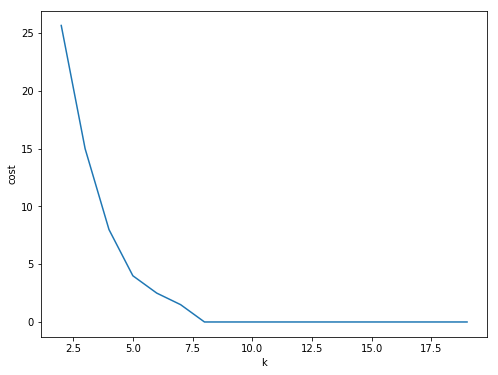

In [105]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

From the graph, we choose the k that start to make no change to y-axis

# Create the model and train/predict the data

In [141]:
from numpy import array
from math import sqrt

kmeans = KMeans(k=10, seed=1)  # 10 clusters here
model = kmeans.fit(train_transformed.select('features'))

In [142]:
predictions = model.transform(train_transformed)

In [70]:
# predictions = model.transform(test_transformed)

# Kmeans Model evaluation using Silhouette method

In [143]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.5894087161853002


Label the outlier to spark dataframe
<li>Add calculated distance column to predictions dataframe</li>
<li>Drop unnecessary column from predictions dataframe</li>
<li>Add Max_distance/Label column to dataframe</li>

In [151]:
from scipy.spatial import distance
columns_drop=['system_hash','user_hash','api_hash','system_vec','user_vec','api_vec','dateFormated','hour','minute'\
             ,'day','month','year','weekday','weekend','monthbegin','monthend','features']
centers = model.clusterCenters()
# print(len(centers))
# for center in centers:
#     print(center)
fixed_entry = centers #for example, the entry against which you want distances
distance_udf = udf(lambda x,y: float(distance.euclidean(x, fixed_entry[y])), FloatType())
predictions = predictions.withColumn('distances', distance_udf(col('features'),col('prediction')))\
.select('*', avg('distances').over(Window.partitionBy('prediction')).alias('avg_distances'),\
       stddev('distances').over(Window.partitionBy('prediction')).alias('std_distances'),\
       max('distances').over(Window.partitionBy('prediction')).alias('max_distances'))\
.drop(*columns_drop)

# max_dist_df = predictions.groupBy("prediction")\
# .agg(max("distances").alias("max_dist"))
# predictions=predictions.join(max_dist_df, ["prediction"], "inner")


In [38]:
predictions.printSchema()

root
 |-- system: string (nullable = true)
 |-- api: string (nullable = true)
 |-- user: string (nullable = true)
 |-- count_req: long (nullable = true)
 |-- req_load: long (nullable = true)
 |-- system_load: long (nullable = false)
 |-- api_load: long (nullable = false)
 |-- user_load: long (nullable = false)
 |-- avg_req: double (nullable = true)
 |-- %diff_req: double (nullable = true)
 |-- avg_sys: double (nullable = true)
 |-- %diff_sys: double (nullable = true)
 |-- avg_api: double (nullable = true)
 |-- %diff_api: double (nullable = true)
 |-- avg_user: double (nullable = true)
 |-- %diff_user: double (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- set: integer (nullable = false)
 |-- prediction: integer (nullable = false)
 |-- distances: float (nullable = true)
 |-- avg_distances: double (nullable = true)
 |-- std_distances: double (nullable = true)
 |-- max_distances: float (nullable = true)



# 2 Benchmark for detect outlier
<li>Define outlier region to be +/- 10% of the max value</li>
<li>Define the datapoint that have the distances further than 2 standard deviation of the mean distance per cluster as an outlier</li>

In [39]:
# outlier_factor=0.1
# alert_udf= udf(lambda max_distances,dist: dist>= max_distances-(max_distances*outlier_factor), BooleanType())
alert_udf= udf(lambda avg_dist,std_dist,dist: dist>= avg_dist+2*std_dist, BooleanType())
alerts = predictions.withColumn('label', alert_udf(col('avg_distances'),col('std_distances'),col('distances')))

# Publish new alert from Kmeans 

In [40]:
alerts_broadcast= alerts.select([c for c in alerts.columns if c in\
                                 {'label','system','api','user','date'}]).where(alerts.label==1)
alerts_broadcast=alerts_broadcast.toDF('system_temp', 'api_temp','user_temp','date','label')

In [ ]:
alerts_broadcast.printSchema()

In [41]:
alerts_email=raw_data.join(alerts_broadcast,[alerts_broadcast.date==raw_data.window.start,\
                                             alerts_broadcast.user_temp==raw_data.user,\
                                            alerts_broadcast.api_temp==raw_data.api,\
                                            alerts_broadcast.system_temp==raw_data.system] , "inner")\
                    .drop('system_temp','api_temp','user_temp','date')
alerts_email.printSchema()

root
 |-- window: struct (nullable = true)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- system: string (nullable = true)
 |-- api: string (nullable = true)
 |-- user: string (nullable = true)
 |-- count_req: long (nullable = true)
 |-- label: boolean (nullable = true)



# Take a glimpse of how the training result looks like

In [152]:
transform_df=predictions.toPandas()
# transform_df.head(10)
print(transform_df['system'].unique())

['phedex' 'couchdb' 'crabserver' 'reqmgr2' 'crabcache' 'dqm' 'dbs'
 'scheddmon' 'wmstats' 'sitedb' 'das' 'wmstatsserver']


In [224]:
import pandas as pd
filter_data=transform_df[(transform_df.system =='phedex')]
filter_data.loc[:,'outlier']=filter_data.apply(lambda x:x['distances']>=x['avg_distances']+x['std_distances'],axis=1)
filter_data[filter_data.avg_distances>=0].head(10)

,system,api,user,count_req,req_load,system_load,api_load,user_load,avg_req,%diff_req,...,avg_user,%diff_user,date,set,prediction,distances,avg_distances,std_distances,max_distances,outlier
0,phedex,filereplicas,/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=dy...,1187,1850,12,2,2,1850.0,0.0,...,2.000000,0.000000,2019-07-19 13:00:00,0,1,0.000000,0.000000,NaN,0.000000,False
49,phedex,lfn2pfn,/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=vc...,5,5,16,7,2,5.0,0.0,...,1.666667,0.200000,2019-07-19 12:38:00,0,6,7.366225,3.112477,1.660669,9.066560,True
93,phedex,lfn2pfn,/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ab...,1,1,16,7,2,1.0,0.0,...,1.666667,0.200000,2019-07-19 12:47:00,0,6,3.657042,3.112477,1.660669,9.066560,False
105,phedex,blockreplicas,/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=pa...,2,2,10,2,1,2.0,0.0,...,1.000000,0.000000,2019-07-19 11:46:00,0,6,3.086715,3.112477,1.660669,9.066560,False
143,phedex,filereplicas,/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=dy...,663,1850,12,2,2,1850.0,0.0,...,2.000000,0.000000,2019-07-19 13:23:00,0,3,21.974728,21.974728,0.000000,21.974728,True
164,phedex,lfn2pfn,/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=hc...,2,2,12,6,2,2.0,0.0,...,1.500000,0.333333,2019-07-19 13:28:00,0,5,3.217069,4.877465,2.033205,17.125338,False
202,phedex,inject,/DC=ch/DC=cern/OU=computers/CN=tier0/vocms001....,7,7,12,2,1,7.0,0.0,...,3.000000,-0.666667,2019-07-19 13:28:00,0,5,6.306994,4.877465,2.033205,17.125338,False
207,phedex,lfn2pfn,/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=co...,7,7,16,7,2,7.0,0.0,...,2.000000,0.000000,2019-07-19 12:19:00,0,5,8.979800,4.877465,2.033205,17.125338,True
220,phedex,lfn2pfn,/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=dm...,2,2,10,6,9,2.0,0.0,...,14.435897,-0.376554,2019-07-19 11:31:00,0,5,5.644970,4.877465,2.033205,17.125338,False
236,phedex,Activity::QualityPlots,/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=dh...,2,2,10,1,1,2.0,0.0,...,1.000000,0.000000,2019-07-19 11:29:00,0,5,3.899492,4.877465,2.033205,17.125338,False


In [225]:
filter_data.set_index('date', inplace=True)

Calculate the Euclidean distance and label the outlier

Make the group of furthest point from cluster center to be the outlier

In [226]:
# import math
# max_df=(filter_data.groupby('prediction'))['distances'].max()
# outlier_factor=0.4
# filter_data.loc[:,'outlier']=filter_data.apply(lambda x:x['distances']>= max_df.loc[x['prediction']]-(max_df.loc[x['prediction']]*outlier_factor), axis=1)

In [227]:
prep=filter_data[['%diff_req','%diff_sys','%diff_api','%diff_user']]
label=filter_data[['outlier']]

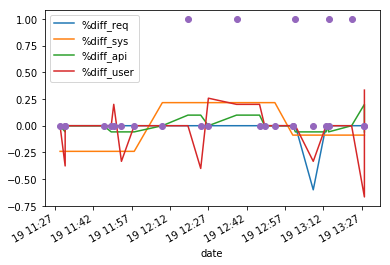

In [229]:
%matplotlib inline

# prep_fix=prep.loc['2019-07-19 11:02:00':'2019-07-19 12:26:00']
# label_fix=label.loc['2019-07-19 11:02:00':'2019-07-19 12:26:00']
# prep_fix.plot()
# plt.plot(prep_fix.index,label_fix.outlier,'o')
prep.plot()
plt.plot(prep.index,label.outlier,'o')

# Email notifier

In [ ]:
from notifier import Notifier
import json
notifier = Notifier(config=json.loads(s='''
{
  "cases": {
    "exit_2": {
      "alert_name": "cms-htcondor-es-validation",
      "email": {
        "send_ok": true,
        "to": [
          "yanisa.sunthornyotin@cern.ch"
        ]
      },
      "entities": [
        "default entity"
      ],
      "snow": {
        "assignment_level": 3,
        "functional_element": "",
        "grouping": true,
        "service_element": "MONITORING"
      },
      "source": "cms-monit-notifier",
      "status": "ERROR",
      "targets": [
        "email",
        "snow"
      ]
    }
  },
  "default_case": {
    "alert_name": "cms-htcondor-es-validation",
    "email": {
      "send_ok": true,
      "to": [
        "yanisa.sunthornyotin@cern.ch"
      ]
    },
    "entities": [
      "default entity"
    ],
    "source": "cms-monit-notifier",
    "status": "OK",
    "targets": [
      "email"
    ]
  },
  "notification_endpoint": "http://monit-alarms.cern.ch:10011"
}'''
                                    ))
sc.addPyFile('notifier.py')

In [ ]:
alert_flow = alerts_email.writeStream\
.foreach(lambda alert: notifier.send_notification(subject=alert.system,description=json.dumps(alert.asDict(), default=str)))\
.start()